# Analytical vs DeepXDE Derivatives  

In this notebook I am comparing analytical derivatives with PINN-based derivatives computed using DeepXDE automatic differentiation.


### Problem Definition

We consider the function

$$u(x) = \sin(\pi x), \quad x \in [0,1]$$

### Analytical derivatives

$$
u'(x) = \pi \cos(\pi x)
$$

$$
u''(x) = -\pi^2 \sin(\pi x)
$$

The goal is to:
- Approximate u(x) using a neural network
- Compute $u'(x)$ and $u''(x)$ using **Jacobian** and **Hessian** from deepxde
- Compare with the analytical derivatives


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

dde.backend.set_default_backend("pytorch")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
def exact_u(x):
    return np.sin(np.pi * x)

def exact_du(x):
    return np.pi * np.cos(np.pi * x)

def exact_d2u(x):
    return -np.pi**2 * np.sin(np.pi * x)


### Data Definition (Pure Regression)

This is **not a PDE-solving problem**. We train the neural network to **interpolate a known function**.
The PDE residual is set to zero:
$$
\mathcal{R}(x) = 0
$$


In [7]:
def pde(x, u):
    return 0

geom = dde.geometry.Interval(0, 1)

data = dde.data.Function(
    geom,
    exact_u,
    num_train=100,
    num_test=200
)



## Neural Network Architecture

We use a fully connected neural network with:
- 3 hidden layers
- Tanh activation (smooth derivatives)
- Glorot initialization

In [4]:
layer_sizes = [1, 50, 50, 50, 1]

net = dde.nn.FNN(
    layer_sizes,
    activation="tanh",
    kernel_initializer="Glorot normal"
)


In [8]:
model = dde.Model(data, net)

model.compile(
    optimizer="adam",
    lr=1e-3
)

model.train(epochs=2000)


Compiling model...
'compile' took 0.001639 s

Training model...

Step      Train loss    Test loss     Test metric
0         [5.04e-01]    [5.07e-01]    []  
1000      [2.53e-04]    [2.47e-04]    []  
2000      [4.53e-05]    [4.38e-05]    []  

Best model at step 2000:
  train loss: 4.53e-05
  test loss: 4.38e-05
  test metric: []

'train' took 1.538362 s



(<deepxde.model.LossHistory at 0x28dcfa380>,
 <deepxde.model.TrainState at 0x28dcf9f30>)

## Model Evaluation and Derivatives

We evaluate:
- Network prediction u(x)
- First derivative u'(x) using Jacobian
- Second derivative u''(x) using Hessian


In [9]:
x = np.linspace(0, 1, 200).reshape(-1, 1)

u_pred = model.predict(x)

du_pred = model.predict(
    x,
    operator=lambda x, u: dde.grad.jacobian(u, x)
)

d2u_pred = model.predict(
    x,
    operator=lambda x, u: dde.grad.hessian(u, x)
)

u_exact = exact_u(x)
du_exact = exact_du(x)
d2u_exact = exact_d2u(x)


## Comparison Plots


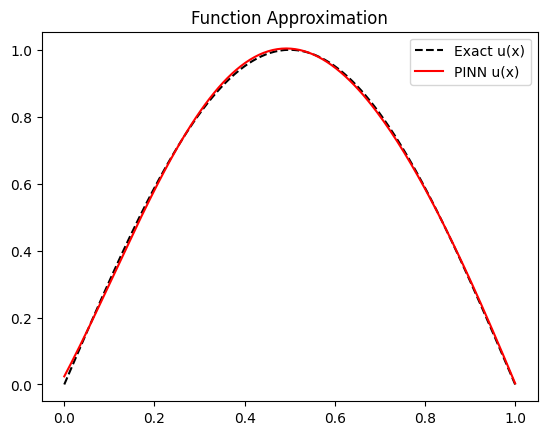

In [10]:
plt.figure()
plt.plot(x, u_exact, "k--", label="Exact u(x)")
plt.plot(x, u_pred, "r", label="PINN u(x)")
plt.legend()
plt.title("Function Approximation")
plt.show()


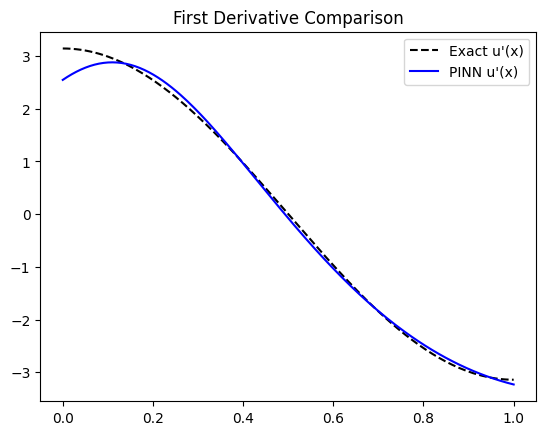

In [11]:
plt.figure()
plt.plot(x, du_exact, "k--", label="Exact u'(x)")
plt.plot(x, du_pred, "b", label="PINN u'(x)")
plt.legend()
plt.title("First Derivative Comparison")
plt.show()


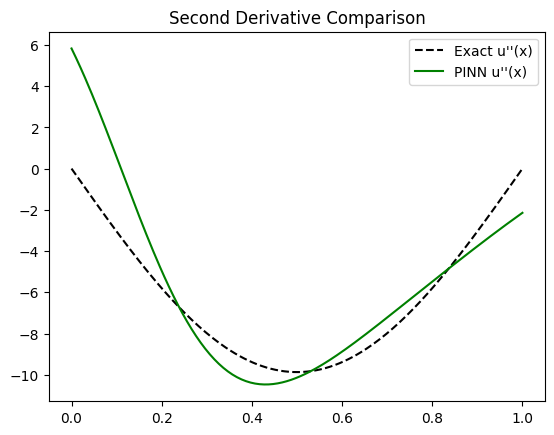

In [12]:
plt.figure()
plt.plot(x, d2u_exact, "k--", label="Exact u''(x)")
plt.plot(x, d2u_pred, "g", label="PINN u''(x)")
plt.legend()
plt.title("Second Derivative Comparison")
plt.show()


## Error Analysis

We compute the L2 norm of the derivative errors.


In [13]:
print("L2 error in u'(x):", np.linalg.norm(du_pred - du_exact, 2))
print("L2 error in u''(x):", np.linalg.norm(d2u_pred - d2u_exact, 2))


L2 error in u'(x): 1.894453375562437
L2 error in u''(x): 26.52028810508383


## Key Takeaways

- **Jacobian** computes first derivatives of the neural network
- **Hessian** computes second derivatives
- PINNs provide smooth, mesh-free differentiation
- Higher-order derivatives are more sensitive to training quality
